[TFL's documentation](https://tfl.gov.uk/info-for/open-data-users/our-open-data?intcmp=3671)

# Import

In [1]:
import pandas
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
raw = pandas.read_csv('../data/tfl_raw.csv')
raw

,downo,daytype,SubSystem,StartStn,EndStation,EntTime,EntTimeHHMM,ExTime,EXTimeHHMM,ZVPPT,JNYTYP,DailyCapping,FFare,DFare,RouteID,FinalProduct
0,3,Tue,LUL,Unstarted,Kings Cross M,0,00:00,633,10:33,Z0104,TKT,N,0,0,XX,LUL Travelcard-7 Day
1,4,Wed,LUL,Unstarted,Sudbury Hill,0,00:00,447,07:27,Z0110,TKT,N,0,0,XX,Freedom Pass (Elderly)
2,3,Tue,NR,Unstarted,Richmond,0,00:00,966,16:06,Z0304,TKT,N,0,0,XX,LUL Travelcard-7 Day
3,4,Wed,NR,Unstarted,Romford,0,00:00,657,10:57,Z0110,TKT,N,0,0,XX,Freedom Pass (Elderly)
4,6,Fri,NR,Unstarted,Norwood Junction SR,0,00:00,450,07:30,Z0104,TKT,N,0,0,XX,LUL Travelcard-7 Day
5,6,Fri,LUL,Unstarted,Clapham Common,0,00:00,439,07:19,Z0104,TKT,N,0,0,XX,LUL Travelcard-7 Day
6,5,Thu,NR,Unstarted,Norwood Junction SR,0,00:00,454,07:34,Z0104,TKT,N,0,0,XX,LUL Travelcard-7 Day
7,5,Thu,NR,Unstarted,Norbury,0,00:00,955,15:55,Z0203,TKT,N,0,0,XX,LUL Travelcard-7 Day
8,5,Thu,LUL,Unstarted,Clapham Common,0,00:00,431,07:11,Z0104,TKT,N,0,0,XX,LUL Travelcard-7 Day
9,2,Mon,LUL,Unstarted,Kings Cross M,0,00:00,498,08:18,Z0104,TKT,N,0,0,XX,LUL Travelcard-7 Day


# Combine stations

See Locations notebook for details.

In [3]:
combine = (
    ('Balham', 'Balham NR', 'Balham SCL'),
    ('Canary Wharf', 'Canary Wharf DLR', 'Canary Wharf E2'),
    ('Euston', 'Euston NR'),
    ('Fenchurch St NR', 'FENCHURCH ST NR'),
    ("Kings Cross St Pancras", 'Kings Cross', 'Kings Cross M', 'Kings Cross T', 'St Pancras International'),
    ('Liverpool Street', 'Liverpool St WAGN TOC Gates', 'Liverpool St NR'),
    ('Marylebone', 'Marylebone NR'),
    ('Paddington', 'Paddington FGW'),
    ('Shepherds Bush', "Shepherd's Bush NR", "Shepherd's Bush Und"),
    ('Shepherds Bush Market', "Shepherd's Bush Mkt"),
    ('Tottenham Court Road', 'Tottenham Court Rd'),
    ('West Hampstead', "West Hampst'd NL", "West Hampst'd Tlink"),
    ('Victoria', 'Victoria TOCs'),
    ('Waterloo', 'Waterloo JLE'),
    ('Blackhorse Lane TRAM', 'BLCKHRS LNE TRAM'),
    ('Caledonian Road & Barnsbury', "Caledonian Rd&B'sby"),
    ('New Addington TRAM', 'NEW ADDNGTH TRAM'),
    ('Beckenham Road TRAM', 'BECKENHM RD TRAM'),
    ('Harringay Green Lanes', 'Harringay Green Las'),
    ('Sudbury & Harrow Rd', 'Sudbury&Harrow Rd'),
    ('Walthamstow Queens Road', 'Walthamstow Qns R'),
    ('Belgrave Walk TRAM', 'BELGRAVE WK TRAM'),
    ('Addington Village TRAM', 'ADDNGTN VIL TRAM'),
    ('Wimbledon', 'WIMBLEDON TRAM'),
)
substitutions = {}
for i in combine:
    for name in i[1:]:
        substitutions[name] = i[0]

Apply substitutions to the data

In [4]:
raw['StartStn'] = raw['StartStn'].str.strip()
raw['EndStation'] = raw['EndStation'].str.strip()
raw['StartStn'].replace(substitutions, inplace=True)
raw['EndStation'].replace(substitutions, inplace=True)

# Validity

In [5]:
complete_journeys = raw[raw['SubSystem'] != 'LTB'][raw['StartStn'] != 'Unstarted'][raw['EndStation'] != 'Unfinished'][raw['EndStation'] != 'Not Applicable']

/mnt/c/Users/Josh/Google Drive_old/Uni/Part III/project/data/env/lib/python3.4/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [6]:
complete_journeys['StartStn'].append(complete_journeys['EndStation']).unique()

array(['Goodge Street', 'Preston Road', 'Holborn', 'Earls Court',
       'Victoria', 'Walthamstow Central', 'Highbury', 'Embankment',
       'Monument', 'South Kensington', "St James's Park", 'Bethnal Green',
       'Tower Hill', 'St Pauls', 'High Barnet', 'All Saints', 'Leyton',
       'Kings Cross St Pancras', 'Manor House', 'Woolwich Arsenal DLR',
       'Putney Bridge', 'Southfields', 'Vauxhall', 'Golders Green',
       'Oxford Circus', 'Fulham Broadway', 'Shadwell DLR', 'Bond Street',
       'Camden Town', 'Piccadilly Circus', 'Maida Vale', 'Clapham South',
       'Hammersmith D', 'Gloucester Road', 'East Finchley',
       'Great Portland St', 'Charing Cross', 'Finchley Road',
       'Notting Hill Gate', 'Waterloo', 'Euston Square', 'Edgware Road M',
       'Chancery Lane', 'Wimbledon', 'Baker Street', 'Ealing Broadway',
       'Euston', 'Covent Garden', 'Sloane Square', 'London Bridge',
       'Hyde Park Corner', 'Paddington', 'Knightsbridge', 'Rayners Lane',
       'Hounslow Cen

# By hour

In [7]:
complete_journeys['EntTimeHHMM']=complete_journeys['EntTimeHHMM'].str.slice(0,2)

## By start and end

In [8]:
start_end_by_hour = complete_journeys.groupby(('StartStn', 'EndStation','daytype', 'EntTimeHHMM')).size()
start_end_by_hour = start_end_by_hour.reset_index()
start_end_by_hour.columns = ['Start station', 'End station', 'Day', 'Entry hour', 'Journey count']
start_end_by_hour.head(7)

,Start station,End station,Day,Entry hour,Journey count
0,AMPERE WAY TRAM,Wimbledon,Fri,08,3
1,AMPERE WAY TRAM,Wimbledon,Fri,10,1
2,AMPERE WAY TRAM,Wimbledon,Fri,13,1
3,AMPERE WAY TRAM,Wimbledon,Fri,16,1
4,AMPERE WAY TRAM,Wimbledon,Mon,10,1
5,AMPERE WAY TRAM,Wimbledon,Mon,16,1
6,AMPERE WAY TRAM,Wimbledon,Mon,17,1


In [9]:
start_end_by_hour.sort_values('Journey count')

,Start station,End station,Day,Entry hour,Journey count
527437,Woolwich Arsenal DLR,Woolwich Arsenal DLR,Wed,16,1
456968,Turnham Green,Victoria,Fri,18,1
276830,Liverpool Street,Liverpool Street,Wed,12,1
456969,Turnham Green,Victoria,Fri,23,1
276828,Liverpool Street,Liverpool Street,Wed,07,1
276827,Liverpool Street,Liverpool Street,Tue,23,1
276826,Liverpool Street,Liverpool Street,Tue,22,1
276825,Liverpool Street,Liverpool Street,Tue,20,1
276824,Liverpool Street,Liverpool Street,Tue,18,1
276823,Liverpool Street,Liverpool Street,Tue,16,1


### Checking

Should both be 765324

In [14]:
start_end_by_hour['Journey count'].sum()

765324

In [11]:
complete_journeys.shape[0]

765324

### Output

In [15]:
start_end_by_hour.to_csv('../data/journey_count.csv', index=False)

# By days

In [12]:
by_day_time = complete_journeys.groupby(('EntTimeHHMM', 'daytype')).size()
by_day_time = by_day_time.reset_index()
by_day_time.columns = ['time', 'day', 'journeys']
by_day_time['time'] = pandas.to_numeric(by_day_time['time'])
by_day_time.head()

,time,day,journeys
0,4,Fri,13
1,4,Mon,7
2,4,Sat,9
3,4,Thu,11
4,4,Tue,9


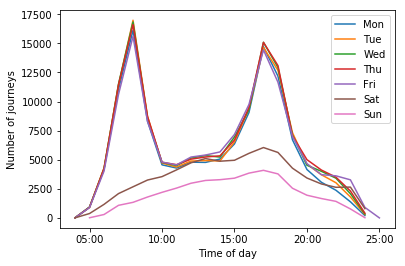

In [13]:
ax = plt.subplot(xlabel='Time of day', ylabel='Number of journeys',)
for day in ('Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'):
    dat = by_day_time[by_day_time['day']==day]
    dat.plot(x='time', y='journeys', ax=ax, label=day)

ax.set_xlabel('Time of day')
ax.set_xticklabels(['{:0>2}:00'.format(int(x)) for x in ax.get_xticks()]);